# Tutorial 8

In this tutorial, we will: 
* Review probabilistic modelling
* Introduce probabilistic programming with *Pyro*
* Train Probabilistic Models using *Pyro*:
    - Bonus: Briefly introduce variational inference
    - Using Pyro to solve a inference problem for Gaussian Mixture Model (GMM)

# Review of Probabilistic Modelling

1. We formulate our knowledge about the world probabilistically
    - We define the model that expresses our knowledge qualitatively (e.g. independence assumptions, forms of distributions).
    - Our model will have some unknown parameters.
    - We capture our assumptions, or prior beliefs, about unknown parameters (e.g. range of plausible values) by specifying the prior distribution over those parameters before seeing the data.
2. We observe the data.
3. We compute the posterior probability distribution for the parameters, given observed data.
4. We use this posterior distribution to:
    - Make predictions by averaging over the posterior distribution
    - Examine/Account for uncertainty in the parameter values.
    - Make decisions by minimizing expected posterior loss.

# Pyro: A Probabilistic Programming Library

__What is Probabilistic Programming?__

"Probabilistic programs are usual functional or imperative programs with two added constructs:
1. the ability to draw values at random from distributions, and
2. the ability to condition values of variables in a program via observations." Gordon et al, 2014


__Pyro__ is a probabilistic programming module based off of PyTorch. 

# Writing probabilistic models in Pyro

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch

from matplotlib.patches import Ellipse
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from torch.distributions import constraints

def plot(data, mus=None, sigmas=None, colors='black', K=2):
    ### Plotting utility
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)
    return


The basic unit of probabilistic programs is the stochastic function. 

This is a python callable that contains deterministic Python code and other primitive stochastic functions that call a random number generator.

__Primitive Stochastic Functions__: These are stochastic functions whose output probabilities can be explicitly computed given inputs. Here is a simple example: 

In [5]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object

# We can sample as many times as we want. 
num_samples = 5
for _ in range(num_samples):
    x = normal.rsample() # draw a sample from N(0,1)
    print("sample", x)
    print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(0.0731)
log prob tensor(-0.9216)
sample tensor(-0.1377)
log prob tensor(-0.9284)
sample tensor(-0.5900)
log prob tensor(-1.0930)
sample tensor(1.2452)
log prob tensor(-1.6942)
sample tensor(-1.0773)
log prob tensor(-1.4993)


__Building Models using Primitive Stochastic Functions__: We can build models by simply combining primitive stochastic functions. 

In [6]:
def weather():
    coin = torch.distributions.Bernoulli(0.3)
    sky = 'cloudy' if coin.sample().item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 45.0, 'sunny': 75.0}[sky]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[sky]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return sky, temp.item()

weather()

('sunny', 58.74293518066406)

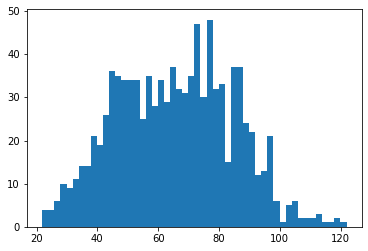

In [7]:
data = [weather() for i in range(1000) ]
temp = [t for _, t in data]
_ = plt.hist(temp, 50)

__Pyro Equivalents of the Above__ So far, we've been using the utilities of PyTorch to construct stochastic functions. We now turn to how this is done using Pyro.

In [8]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(-1.4146)


Almost the same, with one important distinction:  Sample statements are named. This is important, because this way Pyro recognizes that weather() induces a joint probability distribution. This will come in handy later on when we deal with conditioning. 

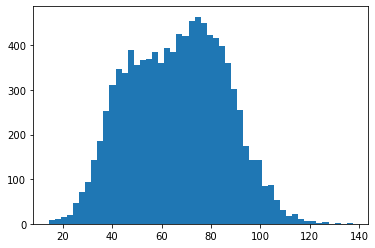

In [9]:
def weather():
    coin = pyro.sample('coin', pyro.distributions.Bernoulli(0.3)) # sample: coin ~ Bernoulli(0.3)
    sky = 'cloudy' if coin.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 45.0, 'sunny': 75.0}[sky] 
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[sky]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp)) 
    return sky, temp.item()

data = [weather() for i in range(10000) ]
temp = [t for _, t in data]
_ = plt.hist(temp, 50)

We can combine/compose stochastic functions to build even more complex stochastic functions. 

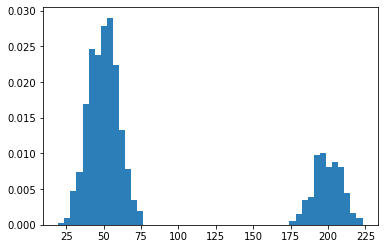

In [10]:
def ice_cream_sales():
    sky, temp = weather()
    expected_sales = 200. if sky == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

sales = [ice_cream_sales() for i in range(1000)]
_ = plt.hist(sales, 50, density=True, alpha=0.95)


Pyro lets us do recursion as well. We can sample from a geometric distribution this way. One caveat: We have to be careful about the sample statements as we do recursion.

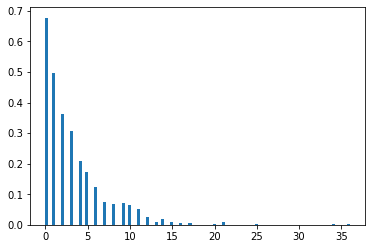

In [11]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

N= 1000
samples = [geometric(0.25) for i in range(N)]
samples
_ = plt.hist(samples, 100, density=True)

We can even accept as input, or produce as output other stochastic functions. 

In [12]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

make_normal_normal()(1.)

tensor(-0.0297)

__Universality__ Thanks to all these things Pyro supports, we can express any stochastic function there could be. In other words, Pyro stochastic functions are *universal*. 



We can define a parameterized model in Pyro using:


``` python 
pyro.param("name",...)
```

In [13]:
def weather(guess=0.3):
    p = pyro.param('p', torch.tensor(guess))
    coin = pyro.sample('coin', pyro.distributions.Bernoulli(p)) # sample: coin ~ Bernoulli(p)
    sky = 'cloudy' if coin.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 45.0, 'sunny': 75.0}[sky] 
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[sky]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp)) 
    return sky, temp.item()
weather()

('sunny', 65.38715362548828)

 Finally for **conditioning**, we can also add "observe" statements in the generative model:

In [14]:
def weather(guess=0.3):
    p = pyro.param('p', torch.tensor(guess))
    coin = pyro.sample('coin', pyro.distributions.Bernoulli(p)) # sample: coin ~ Bernoulli(p)
    sky = 'cloudy' if coin.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 45.0, 'sunny': 75.0}[sky] 
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[sky]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp), 
                       obs=torch.tensor(74.)) # Condition the output to be 75
    return temp.item()
weather()

/data/vision/polina/shared_software/miniconda3/envs/misc_impl/lib/python3.7/site-packages/pyro/primitives.py:83: RuntimeWarning: trying to observe a value outside of inference at temp
  RuntimeWarning)


74.0

### Recall: Gaussian Mixture Model
Now, let's look at how we can write the gaussian mixture model we have studied in class using.

Generative model associated with the GMM was as follows:

First we sample the latent variables according to some mixing proportions

$$(z_1, ..., z_K) \sim \mathrm{Multinomial}((\pi_1, ..., \pi_K))$$

Given the mixture assignment, we sample from the gaussian with mean and variance of the cluster

$$\mathbf{x} ~|~ z_k=1 \sim \mathrm{Gaussian} (\mu_k, \Sigma_k)$$



### Generate Data

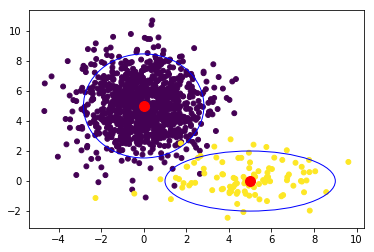

In [34]:
K=2

def generate_data (num_samples, true_locs, true_scales):
    # 2 clusters
    # note that both covariance matrices are diagonal
    mu1 = true_locs[0]
    sig1 = true_scales[0]
    mu2 = true_locs[1]
    sig2 = true_scales[1]

    # generate samples
    dist1 = dist.MultivariateNormal(mu1, sig1)
    samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples[0])]

    dist2 = dist.MultivariateNormal(mu2, sig2)
    samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples[1])]

    data = torch.cat((torch.stack(samples1), torch.stack(samples2)))
    return data


N = [1000, 100]
true_locs = torch.tensor([[0., 5.], [5., 0.]])
true_scales = torch.tensor([[[2., 0.], [0., 3.]], [[4., 0.], [0., 1.]]])
data = generate_data(N, true_locs, true_scales)
true_assignment = [0] * N[0] + [1] * N[1]
plot(data, true_locs, true_scales, true_assignment)

In [35]:
data

tensor([[ 0.0498,  2.6093],
        [-1.4980,  4.9205],
        [-0.2631,  5.9361],
        ...,
        [ 5.7381,  0.0570],
        [ 4.9945,  1.2415],
        [ 3.3174,  2.2933]])

In [13]:
# GMM with K=2

def model(data):
    # Global variables.
    weights = pyro.param('weights', torch.FloatTensor([0.5]), constraint=constraints.unit_interval)
    scales = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]]]), constraint=constraints.positive)
    locs = pyro.param('locs', torch.tensor([[1., 2.], [3., 4.]]))

    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)


## Model learning and Inference in Pyro

We have seen that writing the probabilistic model is easy: All we have to do is write a program with sample statements that represents our beliefs about the world. 

__How do we do something useful?__


### Model Learning
In this context our criterion for learning a good model will be maximizing the log likelihood, i.e. we want to find the value of $\theta$ given by

$$\theta_{\rm{max}} = \underset{\theta}{\operatorname{argmax}} \log p_{\theta}({\bf x})$$

where the log evidence $\log p_{\theta}({\bf x})$ is given by

$$\log p_{\theta}({\bf x}) = \log \int\! d{\bf z}\; p_{\theta}({\bf x}, {\bf z}).$$
In the general case this is a doubly difficult problem. This is because (even for a fixed $\theta$) the integral over the latent random variables $\bf z$ is often intractable. Furthermore, even if we know how to calculate the log evidence for all values of $\theta$, maximizing the log evidence as a function of $\theta$ will in general be a difficult non-convex optimization problem. 

_Note_: For GMM we can run the "Expectation--Maximization" algorithm to get the parameters (we'll get to this in a bit). 

### Inference
In addition to finding $\theta_{\rm{max}}$, we would like to calculate the posterior over the latent variables $\bf z$:

$$ p_{\theta_{\rm{max}}}({\bf z} | {\bf x}) = \frac{p_{\theta_{\rm{max}}}({\bf x} , {\bf z})}{
\int \! d{\bf z}\; p_{\theta_{\rm{max}}}({\bf x} , {\bf z}) } $$

Note that the denominator of this expression is the (usually intractable) evidence. 


Variational inference offers a scheme for finding $\theta_{\rm{max}}$ and computing an approximation to the posterior $p_{\theta_{\rm{max}}}({\bf z} | {\bf x})$.



## Variational Approximation

Introduce a parameterized distribution $q_{\phi}({\bf z})$, where $\phi$ are known as the variational parameters. This distribution is called the variational distribution in much of the literature, and in the context of Pyro it's called the **guide**. The guide will serve as an approximation to the posterior.


Since the guide is an approximation to the posterior $p_{\theta_{\rm{max}}}({\bf z} | {\bf x})$, the guide needs to provide a valid joint probability density over all the latent random variables in the model. 

```python
def model():
    pyro.sample("z_1", ...)
```

then the guide needs to have a matching `sample` statement

```python
def guide():
    pyro.sample("z_1", ...)
```

The distributions used in the two cases can be different, but the names must line-up 1-to-1. 

Once we've specified a guide (we give some explicit examples below), we're ready to proceed to inference.
Learning will be setup as an optimization problem where each iteration of training takes a step in $\theta-\phi$ space that moves the guide closer to the exact posterior.
To do this we need to define an appropriate objective function. 

## Evidence Lower Bound ELBO *


\begin{align*}
\log p_\theta(\mathbf{x}) =& \int q_\phi(\mathbf{z}) \log p_\theta(\mathbf{x}) d\mathbf{z}\\
=& \int q_\phi(\mathbf{z}) \log \frac{p_\theta(\mathbf{x})p_\theta(\mathbf{z} | \mathbf{x})}{p_\theta(\mathbf{z} | \mathbf{x})} d\mathbf{z}\\
=& \int q_\phi(\mathbf{z}) \log \frac{p_\theta(\mathbf{x}, \mathbf{z})}{p_\theta(\mathbf{z} | \mathbf{x})} d\mathbf{z}\\
=& \int q_\phi(\mathbf{z}) \log \frac{p_\theta(\mathbf{x}, \mathbf{z}) q_\phi(\mathbf{z})}{p_\theta(\mathbf{z} | \mathbf{x})q_\phi(\mathbf{z})} d\mathbf{z}\\
=& \int q_\phi(\mathbf{z}) \log \frac{p_\theta(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z})} d\mathbf{z}- \int q_\phi(\mathbf{z}) \log \frac{p_\theta(\mathbf{z} | \mathbf{x})}{q_\phi(\mathbf{z})} d\mathbf{z}\\
=& \mathrm{ELBO}(\theta, \phi) + KL (q_\phi(\mathbf{z}) || p_\theta(\mathbf{z}|\mathbf{x}))
\end{align*}


ELBO is a lower bound to the log evidence, i.e. for all choices of $\theta$ and $\phi$ we have that 

$$\log p_{\theta}({\bf x}) \ge {\rm ELBO}(\theta,\phi) $$

So if we take (stochastic) gradient steps to maximize the ELBO, we will also be pushing the log evidence higher (in expectation). The gap between the ELBO and the log evidence is given by the KL divergence between the guide and the posterior:

$$ \log p_{\theta}({\bf x}) - {\rm ELBO}(\theta, \phi) = 
\rm{KL}\!\left( q_{\phi}({\bf z}) \lVert p_{\theta}({\bf z} | {\bf x}) \right) $$

This KL divergence is a particular (non-negative) measure of 'closeness' between two distributions. So, for a fixed $\theta$, as we take steps in $\phi$ space that increase the ELBO, we decrease the KL divergence between the guide and the posterior, i.e. we move the guide towards the posterior. In the general case we take gradient steps in both $\theta$ and $\phi$ space simultaneously so that the guide and model play chase, with the guide tracking a moving posterior $\log p_{\theta}({\bf z} | {\bf x})$. Perhaps somewhat surprisingly, despite the moving target, this optimization problem can be solved (to a suitable level of approximation) for many different problems.

So at high level variational inference is easy: all we need to do is define a guide and compute gradients of the ELBO. For the purposes of this tutorial, let's consider that a solved problem and look at the support that Pyro provides for doing variational inference. 


## Digression: ELBO and the EM algorithm *

The EM algorithm can be summarized as:

1. E-step: Evaluate $p_{\theta_{OLD}}(\mathbf{z}|\mathbf{x})$
2. M-step: Evaluate $\underset{\theta}{\operatorname{argmax}} \int p_{\theta_{OLD}}(\mathbf{z}|\mathbf{x})\log p_\theta(\mathbf{x},\mathbf{z})d\mathbf{z}$ 

If we pick $q_\phi (\mathbf{z}) =p_{\theta_{OLD}} (\mathbf{z} | \mathbf{x})$ 

\begin{align*}
\mathrm{ELBO}(\theta)=& \int q_\phi(\mathbf{z}) \log \frac{p_\theta(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z})} d\mathbf{z} \\
=& \int p_{\theta_{OLD}} (\mathbf{z} | \mathbf{x}) \log \frac{p_\theta(\mathbf{x}, \mathbf{z})}{p_{\theta_{OLD}} (\mathbf{z} | \mathbf{x})} d\mathbf{z} = \int p_{\theta_{OLD}}(\mathbf{z}|\mathbf{x})\log p_\theta(\mathbf{x},\mathbf{z})d\mathbf{z} - H(p_{\theta_{OLD}})
\end{align*}

Thus at each step of the EM algorithm, we are maximizing the ELBO. 

_Caveat:_ This assumes we can find $p_{\theta_{OLD}}(\mathbf{z}|\mathbf{x})$ analytically (for the Gaussian Mixture Model, this is just a softmax). In general, this is not feasible. 


### Guide for GMM *

Here we indepedence assumption for the variational posterior:

$$q_{\phi}(Z) = \prod_{i=1}^N\prod_{j=1}^K \phi_{ij}^{Z_{ij}}$$

In [14]:
def full_guide(data):
    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), 
                    infer={"enumerate": "sequential"})

In [37]:
pyro.enable_validation(True)
pyro.clear_param_store()
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_iarange_nesting=1)
svi = SVI(model, full_guide, optim, loss=elbo)
loss = svi.loss(model, full_guide, data)
loss

7010.618408203125

locs: tensor([[0.9000, 2.1000],
        [2.9000, 4.1000]], requires_grad=True)
scales: tensor([[[1.1052, 0.0000],
         [0.0000, 2.2103]],

        [[3.3155, 0.0000],
         [0.0000, 4.4207]]], grad_fn=<AddBackward0>)
weights = tensor([0.5000], grad_fn=<ClampBackward>)
assignments: tensor([0.4750, 0.5250, 0.5250,  ..., 0.5250, 0.5250, 0.5250],
       grad_fn=<ClampBackward>)
locs: tensor([[-0.0052,  4.4227],
        [ 0.9007,  4.5003]], requires_grad=True)
scales: tensor([[[2.2840, 0.0000],
         [0.0000, 3.6792]],

        [[5.7123, 0.0000],
         [0.0000, 6.7056]]], grad_fn=<AddBackward0>)
weights = tensor([0.4294], grad_fn=<ClampBackward>)
assignments: tensor([0.3075, 0.2868, 0.3174,  ..., 0.9044, 0.8842, 0.7282],
       grad_fn=<ClampBackward>)
locs: tensor([[-0.0312,  5.1471],
        [ 1.6018,  2.8156]], requires_grad=True)
scales: tensor([[[1.7306, 0.0000],
         [0.0000, 2.3922]],

        [[9.0365, 0.0000],
         [0.0000, 7.8480]]], grad_fn=<AddBackward0>)
wei

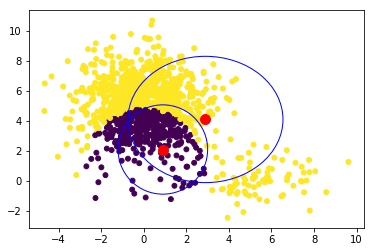

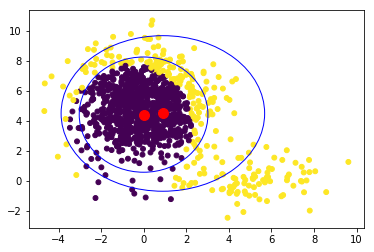

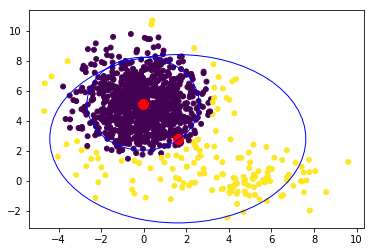

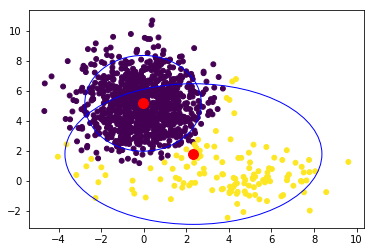

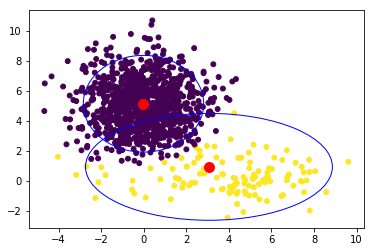

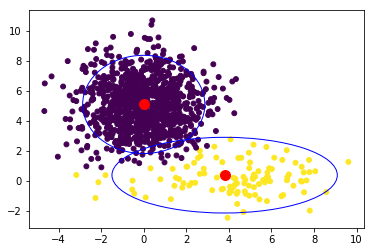

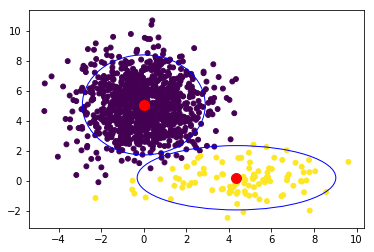

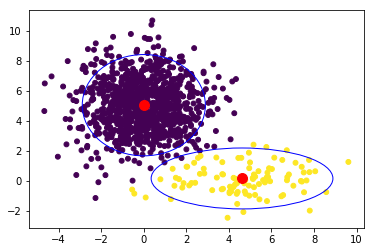

In [38]:
for i in range(400):
    svi.step(data)

    if i % 50 == 0:
        locs = pyro.param('locs')
        scales = pyro.param('scales')
        weights = pyro.param('weights')
        assignment_probs = pyro.param('assignment_probs')

        print("locs: {}".format(locs))
        print("scales: {}".format(scales))
        print('weights = {}'.format(weights))
        print('assignments: {}'.format(assignment_probs))

        # todo plot data and estimates
        assignments = np.uint8(np.round(assignment_probs.data))
        plot(data, locs.data, scales.data, assignments)

In [40]:
assignment_probs

tensor([3.5933e-03, 1.4259e-04, 1.3776e-04,  ..., 9.9860e-01, 9.9610e-01,
        3.5776e-01], grad_fn=<ClampBackward>)

## References

[1] Matt Dickenson, available at https://github.com/mcdickenson/em-gaussian/blob/master/em-gaussian-pyro.py

[2] CSC421 (2019) Course Notes http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/[4] CSC421 (2019) Course Notes http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/

[3] CSC2541 (2017) Course Notes https://csc2541-f17.github.io 

[4] Pyro Documentation, Examples. http://pyro.ai/examples/intro_part_i.html 

[5] Pyro Documentation, Examples. https://pyro.ai/examples/svi_part_i.html

[6] ECE521 (2017) Course Notes https://ece521.github.io/